# BERT dual input

In [2]:
import os

import numpy as np
import tensorflow as tf
import wandb
from sklearn.metrics import (accuracy_score, classification_report,
                             f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from transformers import (DistilBertTokenizer,
                          TFDistilBertForSequenceClassification)
from wandb.keras import WandbCallback

from src.dataset import load_dataset
from src.evaluation import confusion_matrix_plot, acc_plot
from config import DATASETS, PROJECT_NAME

In [3]:
MODEL_NAME = "deepset/gbert-base"
TRACKING = False
FALSE_CLASS_BALANCE = 1.0

dataset = DATASETS["SMC_2000"]

### 0. Load data

In [4]:
train_text_split, X_test, train_labels_split, y_test = load_dataset(dataset_path=os.path.join(dataset["base_path"], dataset["data"]), false_class_balance=FALSE_CLASS_BALANCE)

In [5]:
y_train = train_labels_split.apply(lambda x: 0 if x==False else 1)
y_test = y_test.apply(lambda x: 0 if x==False else 1)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_text_split, train_labels_split, test_size=.2, random_state=42) # train/test

In [7]:
print(X_train.size)
print(X_val.size)
print(y_train.size)

1575
396
525


### 1. Prepare dataset

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # load tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


In [9]:
def tokenize_dataset(sentence, article):
    """Tokenize a list of strings for the BERT model."""
    encoded = tokenizer(
        sentence,
        article,
        padding=True,
        truncation=True,
        return_tensors='np',
    )
    return encoded.data

In [10]:
encodet_train_text = tokenize_dataset(X_train["Sentence"].to_list(), X_train["Article"].to_list())
encodet_val_texts = tokenize_dataset(X_val["Sentence"].to_list(), X_val["Article"].to_list())
encodet_test_texts = tokenize_dataset(X_test["Sentence"].to_list(), X_test["Article"].to_list())

### 2. Create Model

In [11]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Load model

2022-01-18 21:51:19.492953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:51:19.503370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:51:19.503973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:51:19.505563: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [14]:
# Set hyperparameter
learning_rate = 5e-5
epochs = 3
batch_size = 16

In [15]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Some layers from the model checkpoint at deepset/gbert-base were not used when initializing TFDistilBertForSequenceClassification: ['bert', 'mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier', 'pre_classifier', 'distilbert', 'dropout_113']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
model.compile(
    optimizer=optimizer, 
    loss=loss,
    metrics=tf.metrics.SparseCategoricalAccuracy(),
    )

In [17]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 109335552 
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
Total params: 109,927,682
Trainable params: 109,927,682
Non-trainable params: 0
_________________________________________________________________


### 3. Train model

In [18]:
if TRACKING:
  report = []
  model.summary(print_fn=lambda x: report.append(x))

  wandb.init(project=PROJECT_NAME,
          config={
              "model": MODEL_NAME,
              "setup": "\n".join(report),
              "dataset": dataset["name"],
              "train_data_size": len(X_train),
              "validation_data_size": len(X_val),
              "test_data_size": len(X_test),
              "batch_size": batch_size,
              "learning_rate": learning_rate,
              "epochs": epochs,
              "false_class_balance": FALSE_CLASS_BALANCE
          })

In [19]:
history = model.fit(
      encodet_train_text,
      np.array(y_train), 
      validation_data=(encodet_val_texts, np.array(y_val)),
      epochs=epochs, 
      batch_size=batch_size,
      # callbacks=[WandbCallback()]
      )

Epoch 1/3
33/33 [==============================] - 19s 237ms/step - loss: 0.6719 - sparse_categorical_accuracy: 0.6000 - val_loss: 0.6373 - val_sparse_categorical_accuracy: 0.7348
Epoch 2/3
33/33 [==============================] - 6s 172ms/step - loss: 0.5670 - sparse_categorical_accuracy: 0.7314 - val_loss: 0.4716 - val_sparse_categorical_accuracy: 0.7727
Epoch 3/3
33/33 [==============================] - 6s 173ms/step - loss: 0.4246 - sparse_categorical_accuracy: 0.8171 - val_loss: 0.4742 - val_sparse_categorical_accuracy: 0.8258


### 4. Evaluate results

In [20]:
test_loss, test_accuracy = model.evaluate(encodet_test_texts, np.array(y_test))

6/6 [==============================] - 2s 69ms/step - loss: 0.5310 - sparse_categorical_accuracy: 0.7697


In [21]:
preds = model.predict(encodet_test_texts)

In [22]:
y_pred = np.argmax(preds.logits, axis=1)

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.90      0.81        88
           1       0.84      0.62      0.72        77

    accuracy                           0.77       165
   macro avg       0.79      0.76      0.76       165
weighted avg       0.78      0.77      0.76       165



In [24]:
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [25]:
if TRACKING:
    wandb.log({'test_f1': f1})
    wandb.log({'test_recall': recall})
    wandb.log({'test_precision': precision})
    wandb.log({'test_accuracy': accuracy})
    wandb.finish()

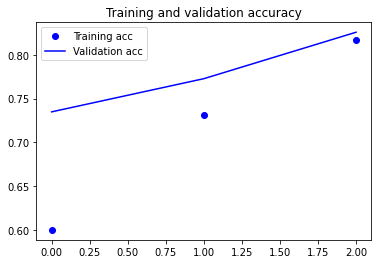

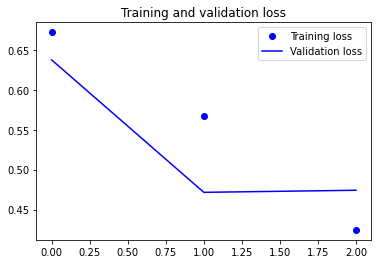

In [26]:
acc_plot(history)

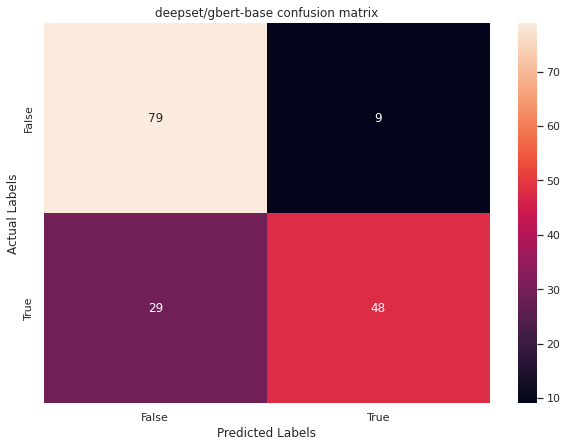

In [27]:
confusion_matrix_plot(y_test, y_pred, label=[False, True], title=MODEL_NAME+" confusion matrix")

In [ ]:
# model.save_pretrained(os.path.join(base_dir, DATASET_CDC_NAME + "_8_dual"))